In [35]:
import napari
from macrohet import dataio, tile, visualise
import btrack
print(btrack.__version__)
import os
import json 
from tqdm.auto import tqdm
import numpy as np
from natsort import natsorted
import glob
from skimage import io
import re
import seaborn as sns
scale_factor = 2 #5.04
ndim = 2

0.6.4


# Load metadata

In [20]:
expt_ID = 'PS0000'
base_dir = f'/mnt/DATA/macrohet/{expt_ID}/'
metadata_path = os.path.join(base_dir, 'acquisition/Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml')
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
assay_layout

Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
Row Column                                              
3   4         RD1     CTRL             0             EC0
    5          WT     CTRL             0             EC0
    6          WT      PZA            60            EC50
    7          WT      RIF           0.1            EC50
    8          WT      INH          0.04            EC50
    9          WT      BDQ          0.02            EC50
4   4         RD1     CTRL             0             EC0
    5          WT     CTRL             0             EC0
    6          WT      PZA            60            EC50
    7          WT      RIF           0.1            EC50
    8          WT      INH          0.04            EC50
    9          WT      BDQ          0.02            EC50
5   4         RD1     CTRL             0             EC0
    5          WT     CTRL             0             EC0
    6          WT      PZA           400            EC99
    7          WT      RIF             2            EC99
    8          WT      INH             2            EC99
    9          WT      BDQ           2.5            EC99
6   4         RD1     CTRL             0             EC0
    5          WT     CTRL             0             EC0
    6          WT      PZA           400            EC99
    7          WT      RIF             2            EC99
    8          WT      INH             2            EC99
    9          WT      BDQ           2.5            EC99

# Load tracks

In [59]:
# Initialize variables and dictionaries
tracks_dict = dict()  # Dictionary to store tracks per acquisition
all_tracks_dict = dict() # compile 
sum_N_frames = 0  # Total number of frames
sum_N_tracks = 0  # Total number of tracks
sum_N_cells = 0  # Total number of cells
sum_N_gt_tracks = 0  # Total number of ground truth tracks
sum_N_tracks_per_acq = dict()  # Dictionary to store number of tracks per acquisition
sum_N_cells_per_acq = dict()  # Dictionary to store number of cells per acquisition
sum_N_gt_tracks_per_acq = dict()  # Dictionary to store number of ground truth tracks per acquisition
track_performance_dict_dict = {}
# Get a list of HDF5 file names
h5_file_list = natsorted(glob.glob(os.path.join(base_dir, f'labels/macrohet_seg_model/*.h5')))

# Loop over each file name
for tracks_fn in tqdm(h5_file_list, total=len(h5_file_list)):
    # Read tracks from the HDF5 file
    with btrack.io.HDF5FileHandler(tracks_fn, 'r') as hdf:
        tracks = hdf.tracks
        # Extract row and column from the file name
        row, column = [int(x) for x in re.search(r'\((\d{1,2}),\s*(\d{1,2})\)\.h5$', tracks_fn).groups()]
        # Update variables and dictionaries
        sum_N_tracks += len(tracks)
        sum_N_tracks_per_acq[(row, column)] = len(tracks)
        sum_N_cells += len([t for t in tracks if t.in_frame(0)])
        sum_N_cells_per_acq[(row, column)] = len([t for t in tracks if t.in_frame(0)])
    all_tracks_dict[row, column] = tracks
    # Load track score dictionary
    track_performance_dict_fn = os.path.join(base_dir, f'upstream_development/tracking/tracking_performance/v1>70/{row},{column}/({row}, {column})_track_assessment.json')
    with open(track_performance_dict_fn, 'r') as json_file:
        # Load the JSON data into a Python dictionary
        track_performance_dict = json.load(json_file)
    track_performance_dict_dict[(row, column)] = track_performance_dict
    if "Link" in track_performance_dict.values():
        print(row, column, 'features linked cells')
        
    # Calculate the number of frames for each acquisition
    N_frames_per_acq = sum([len(t) for t in tracks if str(t.ID) in track_performance_dict.keys()])
    sum_N_frames += N_frames_per_acq

    # Filter tracks based on certain criteria
    tracks = [t for t in tracks if str(t.ID) in track_performance_dict.keys() and track_performance_dict[str(t.ID)] != False]# and len(t) > 70]
    
    # Update variables and dictionaries with filtered tracks
    sum_N_gt_tracks += len(tracks)
    sum_N_gt_tracks_per_acq[(row, column)] = len(tracks)
    tracks_dict[row, column] = tracks

  0%|          | 0/24 [00:00<?, ?it/s]

[INFO][2023/12/13 10:50:42 AM] Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(3, 4).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(3, 4).h5...
[INFO][2023/12/13 10:50:42 AM] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2023/12/13 10:50:42 AM] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2023/12/13 10:50:42 AM] Loading objects/obj_type_1 (39878, 5) (39878 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (39878, 5) (39878 filtered: None)
[INFO][2023/12/13 10:50:43 AM] Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(3, 4).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(3, 4).h5
[INFO][2023/12/13 10:50:43 AM] Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(3, 5).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model

3 5 features linked cells


[INFO][2023/12/13 10:50:44 AM] Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(3, 6).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(3, 6).h5
[INFO][2023/12/13 10:50:44 AM] Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(3, 7).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(3, 7).h5...
[INFO][2023/12/13 10:50:44 AM] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2023/12/13 10:50:44 AM] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2023/12/13 10:50:44 AM] Loading objects/obj_type_1 (42503, 5) (42503 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (42503, 5) (42503 filtered: None)


3 6 features linked cells


[INFO][2023/12/13 10:50:45 AM] Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(3, 7).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(3, 7).h5
[INFO][2023/12/13 10:50:45 AM] Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(3, 8).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(3, 8).h5...
[INFO][2023/12/13 10:50:45 AM] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2023/12/13 10:50:45 AM] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2023/12/13 10:50:45 AM] Loading objects/obj_type_1 (47396, 5) (47396 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (47396, 5) (47396 filtered: None)


3 7 features linked cells


[INFO][2023/12/13 10:50:46 AM] Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(3, 8).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(3, 8).h5
[INFO][2023/12/13 10:50:46 AM] Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(3, 9).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(3, 9).h5...
[INFO][2023/12/13 10:50:46 AM] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2023/12/13 10:50:46 AM] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2023/12/13 10:50:46 AM] Loading objects/obj_type_1 (42259, 5) (42259 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (42259, 5) (42259 filtered: None)
[INFO][2023/12/13 10:50:47 AM] Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(3, 9).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(3

#### Note:
The original tracks I checked were not filtered to be longer than 70 hours (like most of the tracks I checked). Therefore I know there are 248 true tracks of all lengths, but only 107 tracks of length greater than 70. Does this extend to all other positions? If so am I missing 141 tracks per position? What kind of length tracks do I want to analyse anyway?

# Stats

#### How many cells are less than 70?

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

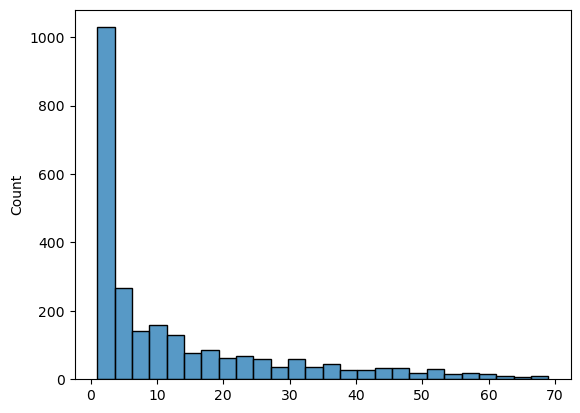

In [39]:
sns.histplot([len(t) for t in tracks if len(t) < 70])

In [51]:
for row_col, data in assay_layout.iterrows():
    tracks = all_tracks_dict[row_col]
    print(f'>70:{len([t for t in tracks if len(t) > 70])}, 50<len<70:{len([t for t in tracks if len(t) < 70 and  len(t) > 50])}')


>70:196, 50<len<70:107
>70:204, 50<len<70:144
>70:223, 50<len<70:175
>70:200, 50<len<70:140
>70:229, 50<len<70:171
>70:215, 50<len<70:174
>70:207, 50<len<70:125
>70:274, 50<len<70:214
>70:226, 50<len<70:171
>70:207, 50<len<70:130
>70:181, 50<len<70:124
>70:227, 50<len<70:154
>70:115, 50<len<70:89
>70:203, 50<len<70:172
>70:245, 50<len<70:168
>70:239, 50<len<70:135
>70:181, 50<len<70:119
>70:91, 50<len<70:143
>70:197, 50<len<70:127
>70:221, 50<len<70:180
>70:230, 50<len<70:148
>70:221, 50<len<70:134
>70:191, 50<len<70:162
>70:125, 50<len<70:153


### First just the numbers of cells in the analysis

In [21]:
sum_N_cells

15252

In [41]:
sum_N_gt_tracks

3988

In [60]:
# all gt tracks, including linked
sum_N_gt_tracks

4418

In [42]:
sum_N_tracks

63033

### Then per acquisition

In [43]:
sum_N_cells_per_acq

{(3, 4): 642,
 (3, 5): 627,
 (3, 6): 652,
 (3, 7): 635,
 (3, 8): 684,
 (3, 9): 566,
 (4, 4): 662,
 (4, 5): 658,
 (4, 6): 591,
 (4, 7): 634,
 (4, 8): 542,
 (4, 9): 641,
 (5, 4): 502,
 (5, 5): 652,
 (5, 6): 664,
 (5, 7): 706,
 (5, 8): 583,
 (5, 9): 595,
 (6, 4): 685,
 (6, 5): 705,
 (6, 6): 660,
 (6, 7): 657,
 (6, 8): 694,
 (6, 9): 615}

In [44]:
sum_N_tracks_per_acq

{(3, 4): 2698,
 (3, 5): 2420,
 (3, 6): 2771,
 (3, 7): 2791,
 (3, 8): 2810,
 (3, 9): 2254,
 (4, 4): 2753,
 (4, 5): 2174,
 (4, 6): 2471,
 (4, 7): 2741,
 (4, 8): 2352,
 (4, 9): 2444,
 (5, 4): 2449,
 (5, 5): 2269,
 (5, 6): 2747,
 (5, 7): 3301,
 (5, 8): 2835,
 (5, 9): 2056,
 (6, 4): 3091,
 (6, 5): 2610,
 (6, 6): 2728,
 (6, 7): 3062,
 (6, 8): 3271,
 (6, 9): 1935}

In [45]:
sum_N_gt_tracks_per_acq

{(3, 4): 178,
 (3, 5): 185,
 (3, 6): 107,
 (3, 7): 175,
 (3, 8): 177,
 (3, 9): 177,
 (4, 4): 165,
 (4, 5): 234,
 (4, 6): 193,
 (4, 7): 175,
 (4, 8): 154,
 (4, 9): 191,
 (5, 4): 98,
 (5, 5): 173,
 (5, 6): 205,
 (5, 7): 187,
 (5, 8): 155,
 (5, 9): 83,
 (6, 4): 166,
 (6, 5): 183,
 (6, 6): 187,
 (6, 7): 175,
 (6, 8): 155,
 (6, 9): 110}

### As a percentage

In [46]:
for key in sum_N_gt_tracks_per_acq:
    n = sum_N_gt_tracks_per_acq[key]
    N = sum_N_cells_per_acq[key]
    print(key, n/N*100)
    

(3, 4) 27.725856697819314
(3, 5) 29.505582137161085
(3, 6) 16.411042944785276
(3, 7) 27.559055118110237
(3, 8) 25.877192982456144
(3, 9) 31.272084805653712
(4, 4) 24.924471299093657
(4, 5) 35.56231003039514
(4, 6) 32.656514382402705
(4, 7) 27.602523659305994
(4, 8) 28.413284132841326
(4, 9) 29.797191887675506
(5, 4) 19.52191235059761
(5, 5) 26.533742331288344
(5, 6) 30.873493975903614
(5, 7) 26.487252124645895
(5, 8) 26.58662092624357
(5, 9) 13.949579831932773
(6, 4) 24.233576642335766
(6, 5) 25.957446808510635
(6, 6) 28.333333333333332
(6, 7) 26.636225266362253
(6, 8) 22.334293948126803
(6, 9) 17.88617886178862


In [74]:
N_trax = 0
for i in tracks_dict.values():
    N_trax += len(i)
    

In [65]:
sum_N_frames

384207

In [ ]:
output_dir = f'/mnt/DATA/macrohet/upstream_development/tracking/tracking_performance/{row},{column}/ground_truth_tracks'

In [19]:
len(track_performance_dict)

194

In [ ]:
track_performance_dict

In [18]:
correct_track_IDs = [key for key in track_performance_dict.keys() if track_performance_dict[key] == True]
print(len(correct_track_IDs))

false_track_IDs = [key for key in track_performance_dict.keys() if track_performance_dict[key] == False]
print(len(false_track_IDs))

linked_track_IDs = [key for key in track_performance_dict.keys() if track_performance_dict[key] == 'Link']
print(len(linked_track_IDs))

178
16
0


In [ ]:
import matplotlib.pyplot as plt

# Assuming you have defined your track_performance_dict dictionary
correct_track_IDs = [key for key in track_performance_dict.keys() if track_performance_dict[key] == True]
false_track_IDs = [key for key in track_performance_dict.keys() if track_performance_dict[key] == False]
linked_track_IDs = [key for key in track_performance_dict.keys() if track_performance_dict[key] == 'Link']

# Get counts
counts = [len(correct_track_IDs), len(false_track_IDs), len(linked_track_IDs)]

# Prepare data
categories = ['Correct', 'False', 'Linked']
colors = ['green', 'pink', 'yellow']  # PIYG color scheme approximation 

# Plot
plt.figure(figsize=(10, 6))
plt.bar(categories, counts, color=colors)
plt.title('Track ID performance')
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.show()

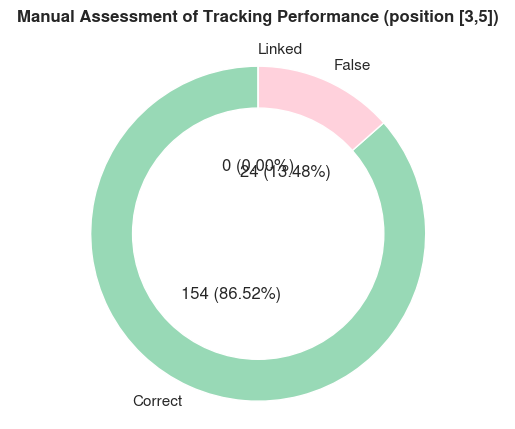

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set the theme and style
sns.set(font='Nimbus Sans', style='white')

# Assuming you have defined your track_performance_dict dictionary
correct_track_IDs = [key for key in track_performance_dict.keys() if track_performance_dict[key] == True]
false_track_IDs = [key for key in track_performance_dict.keys() if track_performance_dict[key] == False]
linked_track_IDs = [key for key in track_performance_dict.keys() if track_performance_dict[key] == 'Link']

# Get counts
counts = [len(correct_track_IDs), len(false_track_IDs), len(linked_track_IDs)]

# Prepare data
categories = ['Correct', 'False', 'Linked']
colors = ['#98d9b6', '#ffd1dc', '#d3d3d3']  # Adjusted color palette 

# Plot
fig, ax = plt.subplots()

# Define autopct function to move labels into the pie
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v:d}'.format(v=val) + ' ({p:.2f}%)'.format(p=pct)
    return my_format

# Draw pie chart
ax.pie(counts, labels=categories, autopct=autopct_format(counts), startangle=90, pctdistance=0.4, colors=colors)

# Draw white circle in the middle for the "donut" style
centre_circle = plt.Circle((0,0),0.750,fc='white')
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle.
ax.axis('equal')  

# Change the font to Helvetica (default font in Apple Keynote)
plt.rcParams['font.family'] = 'Helvetica'

plt.title('Manual Assessment of Tracking Performance (position [3,5])', pad=20, weight='bold')

# plt.savefig(os.path.join(output_dir, 'track_performance_pie_chart_3,5_ground_truth.png'), 
#             bbox_inches='tight', dpi=314)

plt.show()


In [ ]:
total_len=0
for cell_ID in tqdm(track_performance_dict.keys()):
    if isinstance(cell_ID, str):
        cell_ID1 = int(cell_ID.split(',')[0])
        track_len1 = len([t for t in tracks if t.ID == cell_ID1][0])
        cell_ID2 = int(cell_ID.split(',')[1])
        track_len2 = len([t for t in tracks if t.ID == cell_ID2][0])
        track_len = track_len1+track_len2
    else:
        track_len = len([t for t in tracks if t.ID == cell_ID][0])
    total_len += track_len

In [ ]:
total_len


# Creating heatmap for track quality

Correlate to density? Movement? etc.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set the theme
sns.set(font='Nimbus Sans', style='white')

correct_x, correct_y = [], []
false_x, false_y = [], []

for cell_ID in track_performance_dict.keys():
    if isinstance(cell_ID, str):
        continue
    track = [t for t in tracks if t.ID == int(cell_ID)][0]
    if track_performance_dict[cell_ID] == True:
        correct_x.extend(track.x)
        correct_y.extend(track.y)
    elif track_performance_dict[cell_ID] == False:
        false_x.extend(track.x)
        false_y.extend(track.y)

# Preparing the grid for the histogram
x_bins = np.linspace(min(min(correct_x), min(false_x)), max(max(correct_x), max(false_x)), 10)
y_bins = np.linspace(min(min(correct_y), min(false_y)), max(max(correct_y), max(false_y)), 10)

# Plotting the heatmap for correctly tracked cells
plt.figure(figsize=(10, 8))
plt.hist2d(correct_x, correct_y, bins=[x_bins, y_bins], cmap='Greens')
plt.colorbar(label='Number of Correctly Tracked Cells')
plt.title('Heatmap of Correctly Tracked Cells')
plt.xlabel('X Position')
plt.ylabel('Y Position')

plt.savefig(os.path.join(output_dir, 'heatmap_correct_tracks_3,5_ground_truth.png'), 
            bbox_inches='tight', dpi=314)
plt.show()

# Plotting the heatmap for falsely tracked cells
plt.figure(figsize=(10, 8))
plt.hist2d(false_x, false_y, bins=[x_bins, y_bins], cmap='Reds')
plt.colorbar(label='Number of Falsely Tracked Cells')
plt.title('Heatmap of Falsely Tracked Cells')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.savefig(os.path.join(output_dir, 'heatmap_false_tracks_3,5_ground_truth.png'), 
            bbox_inches='tight', dpi=314)

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font='Nimbus Sans', style='white')

# Get the first ten frames
frames = range(10)

# Filter tracks for the first ten frames
tracks_first_10_frames = [track for track in tracks if any(track.in_frame(frame) for frame in frames)]

# Get the x and y coordinates for the filtered tracks
x_coords = [coord for track in tracks_first_10_frames for coord in track.x[:10]]
y_coords = [coord for track in tracks_first_10_frames for coord in track.y[:10]]

# Create the density map using plt.hist2d()
heatmap, xedges, yedges, _ = plt.hist2d(x_coords, y_coords, bins=10, cmap='PiYG')
plt.colorbar(label='Density')

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Density Map of Cell Detections (First 10 Frames)')


plt.savefig(os.path.join(output_dir, 'heatmap_cells_t0-10_3,5_ground_truth.png'), 
            bbox_inches='tight', dpi=314)

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


# Scale the x and y coordinates by 5.04
scaled_false_x = [coord * 5.04 for coord in false_x]
scaled_false_y = [coord * 5.04 for coord in false_y]

scaled_x_coords = [coord * 5.04 for coord in x_coords]
scaled_y_coords = [coord * 5.04 for coord in y_coords]

# Set the figure size for both plots
plt.figure(figsize=(12, 6))

# Plot the KDE density plot of falsely tracked cells
plt.subplot(1, 2, 1)  # Create the first subplot
sns.kdeplot(scaled_false_x, scaled_false_y, cmap='Reds', shade=True, shade_lowest=False)
plt.xlim(0, 1200 * 5.04)
plt.ylim(0, 1200 * 5.04)
plt.xlabel('X Coordinate ')
plt.ylabel('Y Coordinate ')
plt.title('Density of Falsely Tracked Cells')

# Plot the KDE density plot of cell detections (first 10 frames)
plt.subplot(1, 2, 2)  # Create the second subplot
sns.kdeplot(scaled_x_coords, scaled_y_coords, cmap='Blues', shade=True, shade_lowest=False)
plt.xlim(0, 1200 * 5.04)
plt.ylim(0, 1200 * 5.04)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Density of Cell Detections (First 10 Frames)')

# Share the same x and y labels
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('Comparison of Density Plots', fontsize=16, y=1.05)

# Remove the spines
sns.despine()


plt.savefig(os.path.join(output_dir, 'density_false_tracks_cell_detec_0-10_3,5_ground_truth.png'), 
            bbox_inches='tight', dpi=314)
# Show the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scale the x and y coordinates by 5.04
scaled_false_x = [coord * 5.04 for coord in correct_x]
scaled_false_y = [coord * 5.04 for coord in correct_y]

scaled_x_coords = [coord * 5.04 for coord in x_coords]
scaled_y_coords = [coord * 5.04 for coord in y_coords]

# Set the figure size for both plots
plt.figure(figsize=(12, 6))

# Plot the KDE density plot of falsely tracked cells
plt.subplot(1, 2, 1)  # Create the first subplot
sns.kdeplot(scaled_false_x, scaled_false_y, cmap='Greens', shade=True, shade_lowest=False)
plt.xlim(0, 1200 * 5.04)
plt.ylim(0, 1200 * 5.04)
plt.xlabel('X Coordinate ')
plt.ylabel('Y Coordinate ')
plt.title('Density of Correctly Tracked Cells')

# Plot the KDE density plot of cell detections (first 10 frames)
plt.subplot(1, 2, 2)  # Create the second subplot
sns.kdeplot(scaled_x_coords, scaled_y_coords, cmap='Blues', shade=True, shade_lowest=False)
plt.xlim(0, 1200 * 5.04)
plt.ylim(0, 1200 * 5.04)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Density of Cell Detections (First 10 Frames)')

# Share the same x and y labels
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('Comparison of Density Plots', fontsize=16, y=1.05)

# Remove the spines
sns.despine()

plt.savefig(os.path.join(output_dir, 'density_true_tracks_cell_detec_0-10_3,5_ground_truth.png'), 
            bbox_inches='tight', dpi=314)
# Show the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Lists to store the coordinates
correct_x, correct_y = [], []
infected_x, infected_y = [], []

# Iterate over the tracks and separate the coordinates based on track performance and infection status
for track in tracks:
    if track.ID in track_performance_dict.keys():
        if track_performance_dict[track.ID] == True:
            correct_x.extend(track.x)
            correct_y.extend(track.y)
        if track.properties['Infected'][0] == 1:
            infected_x.extend(track.x)
            infected_y.extend(track.y)

# Set the figure size for both plots
plt.figure(figsize=(12, 6))

# Plot the KDE density plot of correctly tracked cells
plt.subplot(1, 2, 1)  # Create the first subplot
sns.kdeplot(correct_x, correct_y, cmap='Greens', shade=True, shade_lowest=False)
plt.xlim(0, 1200)
plt.ylim(0, 1200)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Density of Correctly Tracked Cells')

# Plot the KDE density plot of infected cells
plt.subplot(1, 2, 2)  # Create the second subplot
sns.kdeplot(infected_x, infected_y, cmap='Blues', shade=True, shade_lowest=False)
plt.xlim(0, 1200)
plt.ylim(0, 1200)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Density of Infected Cells')

# Share the same y label
plt.ylabel('Y Coordinate')

# Share the same x and y labels
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('Comparison of Density Plots', fontsize=16, y=1.05)

# Remove the spines
sns.despine()


plt.savefig(os.path.join(output_dir, 'density_correct_tracks_infected_cells_3,5_ground_truth.png'), 
            bbox_inches='tight', dpi=314)

# Show the plot
plt.show()


### Comparison of image based density and density of incorrectly tracked cells

In [ ]:
image_dir = os.path.join(base_dir, 'macrohet_images/Images')
first_frame = tile.compile_mosaic(image_dir, 
                             metadata, 
                             row, column, 
                             set_plane='sum_proj',
#                              set_channel=1,
                             set_time = 0,
#                             input_transforms = [input_transforms]
                            ).compute().compute()

In [ ]:
first_frame.shape

In [ ]:
gfp_t0 = first_frame[0]
rfp_t0 = first_frame[1]

In [ ]:
flipped_gfp = np.flipud(gfp_t0)
flipped_rfp = np.flipud(rfp_t0)

In [ ]:
viewer.add_image(flipped_gfp, 
                 contrast_limits=[100, 6000],
                 )
viewer.add_image(flipped_rfp, 
                 contrast_limits=[100, 2000],
                 )

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# # Scale the x and y coordinates by 5.04
# scaled_x_coords = [coord * 5.04 for coord in x_coords]
# scaled_y_coords = [coord * 5.04 for coord in y_coords]

# Scale the x and y coordinates by 5.04
scaled_false_x = [coord * 5.04 for coord in false_x]
scaled_false_y = [coord * 5.04 for coord in false_y]


# Set the figure size for both plots
plt.figure(figsize=(10, 10))

# Remove axis labels and tick marks
plt.axis('off')

# Load and overlay the image
image = plt.imread("/home/dayn/r03c05f0-p0-ch1sk1fk1fl1.png")
plt.imshow(np.flipud(image), extent=[0, 1200 * 5.04, 0, 1200 * 5.04], alpha=1)

# Plot the KDE density plot of cell detections (first 10 frames)
sns.kdeplot(scaled_false_x, scaled_false_y, cmap='PiYG_r', levels=15, linewidths=3, alpha=0.8)

# Set the image and KDE plot in the center
plt.xlim(0, 1200 * 5.04)
plt.ylim(0, 1200 * 5.04)

# Add a black border with width 50
plt.gca().spines['top'].set_color('black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['right'].set_color('black')
plt.gca().spines['top'].set_linewidth(50)
plt.gca().spines['bottom'].set_linewidth(50)
plt.gca().spines['left'].set_linewidth(50)
plt.gca().spines['right'].set_linewidth(50)

# Remove the spines
sns.despine()

# # Save the plot with a black border
# plt.savefig('/home/dayn/density_false_tracks_r03c05.png', bbox_inches='tight', pad_inches=0, transparent=True)

plt.title('Density of false tracks overlaid on first frame of timelapse (position 3,5)')
# Show the plot


plt.savefig(os.path.join(output_dir, 'density_false_tracks_overlay_15lvl_3,5_ground_truth.png'), 
            bbox_inches='tight', dpi=314)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# # Scale the x and y coordinates by 5.04
# scaled_x_coords = [coord * 5.04 for coord in x_coords]
# scaled_y_coords = [coord * 5.04 for coord in y_coords]

# Scale the x and y coordinates by 5.04
scaled_false_x = [coord * 5.04 for coord in false_x]
scaled_false_y = [coord * 5.04 for coord in false_y]


# Set the figure size for both plots
plt.figure(figsize=(10, 10))

# Remove axis labels and tick marks
plt.axis('off')

# Load and overlay the image
image = plt.imread("/home/dayn/r03c05f0-p0-ch1sk1fk1fl1.png")
plt.imshow(np.flipud(image), extent=[0, 1200 * 5.04, 0, 1200 * 5.04], alpha=1)

# Plot the KDE density plot of cell detections (first 10 frames)
sns.kdeplot(scaled_false_x, scaled_false_y, cmap='PiYG_r', levels=15, linewidths=5, alpha=0.8)

# Set the image and KDE plot in the center
plt.xlim(0, 1200 * 5.04)
plt.ylim(0, 1200 * 5.04)

# Remove the spines
sns.despine()

# # Save the plot with a black border
# plt.savefig('/mnt/DATA/macrohet/upstream_development/tracking/tracking_performance/3,5/ground_truth_tracks/density_false_tracks_r03c05_t01_15lvls.png', 
#             bbox_inches='tight', pad_inches=0, transparent=True)

plt.title('Density of false tracks overlaid on first frame of timelapse (position 3,5)')
# Show the plot

plt.savefig(os.path.join(output_dir, 'density_false_tracks_overlay_15lvl_thicker_3,5_ground_truth.png'), 
            bbox_inches='tight', dpi=314)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scale the x and y coordinates by 5.04
scaled_false_x = [coord * 5.04 for coord in false_x]
scaled_false_y = [coord * 5.04 for coord in false_y]

# Set the figure size for both plots
plt.figure(figsize=(10, 10))

# Remove axis labels and tick marks
plt.axis('off')

# Load and overlay the image
image = plt.imread("/home/dayn/r03c05f0-p0-ch1sk1fk1fl1_with_IDs.png")
plt.imshow(np.flipud(image), extent=[0, 1200 * 5.04, 0, 1200 * 5.04], alpha=1)

# Plot the KDE density plot of cell detections (first 10 frames)
sns.kdeplot(scaled_false_x, scaled_false_y, cmap='PiYG_r', levels=15, linewidths=5, alpha=0.666)

# Set the image and KDE plot in the center
plt.xlim(0, 1200 * 5.04)
plt.ylim(0, 1200 * 5.04)

# Invert the y-axis
plt.gca().invert_yaxis()

# Add a black border with width 50
plt.gca().spines['top'].set_color('black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['right'].set_color('black')
plt.gca().spines['top'].set_linewidth(50)
plt.gca().spines['bottom'].set_linewidth(50)
plt.gca().spines['left'].set_linewidth(50)
plt.gca().spines['right'].set_linewidth(50)

# Remove the spines
sns.despine()

# # Save the plot with a black border
# plt.savefig('/mnt/DATA/macrohet/upstream_development/tracking/tracking_performance/3,5/ground_truth_tracks/density_false_tracks_r03c05_t01_15lvls_IDs.png', 
#             bbox_inches='tight', pad_inches=0, transparent=True)

plt.title('Density of false tracks overlaid on first frame of timelapse (position 3,5)')


plt.savefig(os.path.join(output_dir, 'density_false_tracks_overlay_15lvl_IDs_3,5_ground_truth.png'), 
            bbox_inches='tight', dpi=314)
# Show the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scale the x and y coordinates by 5.04
scaled_correct_x = [coord * 5.04 for coord in correct_x]
scaled_correct_y = [coord * 5.04 for coord in correct_y]


# Set the figure size for both plots
plt.figure(figsize=(10, 10))

# Remove axis labels and tick marks
plt.axis('off')

# Load and overlay the image
image = plt.imread("/home/dayn/r03c05f0-p0-ch1sk1fk1fl1_with_IDs.png")
plt.imshow(np.flipud(image), extent=[0, 1200 * 5.04, 0, 1200 * 5.04], alpha=1)

# Plot the KDE density plot of cell detections (first 10 frames)
sns.kdeplot(scaled_correct_x, scaled_correct_y, cmap='PiYG', levels=15, linewidths=5, alpha=0.666)

# Set the image and KDE plot in the center
plt.xlim(0, 1200 * 5.04)
plt.ylim(0, 1200 * 5.04)

# Invert the y-axis
plt.gca().invert_yaxis()

# Add a black border with width 50
plt.gca().spines['top'].set_color('black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['right'].set_color('black')
plt.gca().spines['top'].set_linewidth(50)
plt.gca().spines['bottom'].set_linewidth(50)
plt.gca().spines['left'].set_linewidth(50)
plt.gca().spines['right'].set_linewidth(50)

# Remove the spines
sns.despine()

plt.title('Density of correct tracks overlaid on first frame of timelapse (position 3,5)')

plt.savefig(os.path.join(output_dir, 'density_correct_tracks_overlay_15lvl_IDs_3,5_ground_truth.png'), 
            bbox_inches='tight', dpi=314)
# Show the plot
plt.show()


# Creating animation showing true tracks

In [ ]:
true_IDs = [int(ID) for ID, status in track_performance_dict.items() if status is True]
true_tracks = [t for t in tracks if t.ID in true_IDs]

In [ ]:
false_IDs = [int(ID) for ID, status in track_performance_dict.items() if status is False]
false_tracks = [t for t in tracks if t.ID in false_IDs]

In [ ]:
len(true_tracks), len(false_tracks)

In [ ]:
true_napari_tracks, properties, graph = btrack.utils.tracks_to_napari(true_tracks, ndim=ndim)

In [ ]:
viewer.add_tracks(true_napari_tracks, scale = (1,scale_factor,scale_factor))

# Can we characterise the true tracks vs false tracks??

In [ ]:
sns.set(font='Nimbus Sans', style = 'white')

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# Calculate the track lengths for true tracks and false tracks
true_track_lengths = [len(t) for t in true_tracks]
false_track_lengths = [len(t) for t in false_tracks]

# Set the color palette for true and false tracks
colors = sns.color_palette('PiYG')

# Plot the histogram
sns.histplot(true_track_lengths, color=colors[-1], label='True Tracks')
sns.histplot(false_track_lengths, color=colors[0], label='False Tracks', alpha = 0.333)

# Add labels and title
plt.xlabel('Track Length')
plt.ylabel('Count')
plt.title('Distribution of Track Lengths')

# Remove spines and set offset
sns.despine(offset=10)

# Add legend
plt.legend()

plt.savefig(os.path.join(output_dir, 'distribution_true_false_track_lengths_3,5_ground_truth.png'), 
            bbox_inches='tight', dpi=314)

# Show the plot
plt.show()


In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# Calculate the track lengths for true tracks and false tracks
true_track_area_t0 = [t.properties['area'][0] for t in true_tracks]
false_track_area_t0 = [t.properties['area'][0] for t in false_tracks]

# Set the color palette for true and false tracks
colors = sns.color_palette('PiYG')

# Plot the histogram
sns.histplot(true_track_area_t0, color=colors[-1], label='True Tracks')
sns.histplot(false_track_area_t0, color=colors[0], label='False Tracks', alpha = 0.5)

# Add labels and title
plt.xlabel('Cell Area at t = 0')
plt.ylabel('Count')
plt.title('Distribution of t = 0 area between correct and false tracks')

# Remove spines and set offset
sns.despine(offset=10)

# Add legend
plt.legend()

plt.savefig(os.path.join(output_dir, 'distribution_true_false_track_areas_t0_3,5_ground_truth.png'), 
            bbox_inches='tight', dpi=314)

# Show the plot
plt.show()


In [ ]:
true_tracks[0]

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# Calculate the track lengths for true tracks and false tracks
true_track_mtb_t0 = [t.properties['mean_intensity'][2][0] for t in true_tracks]
false_track_mtb_t0 = [t.properties['mean_intensity'][2][0] for t in false_tracks]

# Set the color palette for true and false tracks
colors = sns.color_palette('PiYG')

# Plot the histogram
sns.histplot(true_track_mtb_t0, color=colors[-1], label='True Tracks')
sns.histplot(false_track_mtb_t0, color=colors[0], label='False Tracks', alpha = 0.5)

# Add labels and title
plt.xlabel('Mtb measure at t = 0')
plt.ylabel('Count')
plt.title('Distribution of t = 0 Mtb measure between correct and false tracks')

# Remove spines and set offset
sns.despine(offset=10)

# Add legend
plt.legend()

plt.savefig(os.path.join(output_dir, 'distribution_true_false_track_mtb_t0_3,5_ground_truth.png'), 
            bbox_inches='tight', dpi=314)

# Show the plot
plt.show()


# Truer sense of tracking performance

By counting the number of cells and comparing the number of true tracks to that, rather than just hte ratio of true tracks to false which will include fragmented tracks

In [ ]:
N_cells = 0
for i in range(0, 9):
    N_cells+= np.max(segmentation[i])
N_cells = N_cells/9
print(int(N_cells))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set the theme and style
sns.set(font='Nimbus Sans', style='white')

# Assuming you have defined your track_performance_dict dictionary
correct_track_IDs = [key for key in track_performance_dict.keys() if track_performance_dict[key] == True]
false_track_IDs = [key for key in track_performance_dict.keys() if track_performance_dict[key] == False]
linked_track_IDs = [key for key in track_performance_dict.keys() if track_performance_dict[key] == 'Link']

N_cells = 0
for i in range(0, 9):
    N_cells += np.max(segmentation[i])
N_cells = N_cells / 9

N_false = N_cells - len(correct_track_IDs) - len(linked_track_IDs)

# Get counts
counts = [len(correct_track_IDs), 
          N_false,
          # len(false_track_IDs),
          len(linked_track_IDs)]

# Prepare data
categories = ['Correct', 'False', 'Linked']
colors = ['#98d9b6', '#ffd1dc', '#d3d3d3']  # Adjusted color palette 

# Plot
fig, ax = plt.subplots()

# Define autopct function to move labels into the pie
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return '{v:d}'.format(v=val) + ' ({p:.2f}%)'.format(p=pct)
    return my_format

# Draw pie chart
ax.pie(counts, labels=categories, autopct=autopct_format(counts), startangle=90, pctdistance=0.4, colors=colors)

# Draw white circle in the middle for the "donut" style
centre_circle = plt.Circle((0, 0), 0.750, fc='white')
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle.
ax.axis('equal')  

# Change the font to Helvetica (default font in Apple Keynote)
plt.rcParams['font.family'] = 'Helvetica'

# Add title and subtitle
plt.title('Manual Assessment of Tracking Performance (position 3,5)', pad=20, weight='bold')
sns.set(font='Nimbus Sans', style='white')
plt.text(0, 1.15, 'Fragmented false tracks removed', ha='center', va='center', fontsize=11)

plt.savefig(os.path.join(output_dir, 'true_measure_track_performance_pie_chart_3,5_ground_truth.png'), 
            bbox_inches='tight', dpi=314)

plt.show() 


In [ ]:
output_dir

In [ ]:
temp_v = napari.Viewer()

temp_v.add_image(segmentation, scale=(100,1,1))